In [1]:
import os
import numpy as np
from tqdm import tqdm
import random

from mne.channels import make_standard_montage
from mne.io import read_raw_edf
from mne.datasets import eegbci
from mne import events_from_annotations, Epochs, pick_types, concatenate_epochs
from mne.decoding import Scaler

subjects = [i for i in range(1, 110)]
exclusions = [88, 89, 92, 100]
subjects = [i for i in subjects if i not in exclusions]

# subjects = [99, 104, 3, 41, 109, 97]
print(subjects)



[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 90, 91, 93, 94, 95, 96, 97, 98, 99, 101, 102, 103, 104, 105, 106, 107, 108, 109]


In [2]:

"""
4, 8, 12: Motor imagery: T1: left vs T2: right hand
6, 10, 14: Motor imagery: T1: hands vs T2: feet
"""

"""
0: left
1: right
2: fist
3: feet
"""

# dataset_path = 'dataset/physionet.org/files/eegmmidb/1.0.0/S001/S001R01.edf'
dataset_path = 'dataset/physionet.org/files/eegmmidb/1.0.0/'

runs = [4, 6, 8, 10, 12, 14]  # motor imagery: hands vs feet

delta = 1. / 160.

whole_data = []
whole_label = []

for subject in tqdm(subjects):
    subject_data = []
    subject_label = []
    for run in runs:
        fname = os.path.join(dataset_path, f"S{subject:03d}", f"S{subject:03d}R{run:02d}.edf")
        raw = read_raw_edf(fname, preload=True, verbose=False)
        eegbci.standardize(raw)  # set channel names
        montage = make_standard_montage('standard_1005')
        raw.set_montage(montage)

        # strip channel names of "." characters
        raw.rename_channels(lambda x: x.strip('.'))

        if run in [4, 8, 12]:
            events, event_id = events_from_annotations(raw, event_id=dict(T1=0, T2=1), verbose=False)
        elif run in [6, 10, 14]:
            events, event_id = events_from_annotations(raw, event_id=dict(T1=2, T2=3), verbose=False)

        picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')

        delta = 1. / raw.info['sfreq']
        epochs = Epochs(raw, events, event_id=event_id, tmin=0, tmax=100/160 - delta, baseline=None, preload=True, proj=False, picks=picks, verbose=False)
        
        data = epochs.get_data()
        label = epochs.events[:, -1]

        subject_data.append(data)
        subject_label.append(label)

    subject_data = np.vstack(subject_data)
    subject_label = np.hstack(subject_label)
    
    whole_data.append(subject_data)
    whole_label.append(subject_label)

whole_data = np.vstack(whole_data).astype(np.float32)
whole_label = np.hstack(whole_label)

100%|██████████| 105/105 [00:28<00:00,  3.67it/s]


In [3]:
scaler = Scaler(scalings='mean')
whole_data = scaler.fit_transform(whole_data)

In [4]:
from sklearn.model_selection import train_test_split
from params import PARAMS
from train import get_dataloaders

random_seed = 0
X_train, X_test, y_train, y_test = train_test_split(whole_data, whole_label, test_size=PARAMS['TEST_SIZE'], shuffle=True, random_state=random_seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=PARAMS['VALID_SIZE'], shuffle=True, random_state=random_seed)
print('Data sizes:')
print('Train sizes:')
print(X_train.shape)
print(y_train.shape)
print('Valid sizes:')
print(X_valid.shape)
print(y_valid.shape)
print('Test sizes:')
print(X_test.shape)
print(y_test.shape)

dataloaders = get_dataloaders(X_train, y_train, X_valid, y_valid, X_test, y_test, PARAMS['BATCH_SIZE'], random_seed=random_seed, device=PARAMS['DEVICE'])

Data sizes:
Train sizes:
(7558, 64, 100)
(7558,)
Valid sizes:
(945, 64, 100)
(945,)
Test sizes:
(945, 64, 100)
(945,)


In [5]:
from models import GCNAuto
from main import init_model_params
import torch
from train import train_model_2

RANDOM_SEED = random_seed
N_EPOCHS = 100


model = GCNAuto(kernel_type='a',
        in_features=PARAMS['SEQ_LEN'], 
        n_nodes=PARAMS['N_CHANNELS'], 
        num_classes=PARAMS['N_CLASSES'], 
        hidden_sizes=PARAMS['GCNAUTO_HIDDEN_SIZES'], 
        dropout_p=PARAMS['GCNAUTO_DROPOUT_P'], 
        device=PARAMS['DEVICE'])

model = init_model_params(model, random_seed=RANDOM_SEED)
model.init_node_embeddings()

model = model.to(PARAMS['DEVICE'])

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=PARAMS['LR'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

# best_model, history = train_model(dataloaders, dataset_sizes, model, criterion, optimizer, scheduler, PARAMS['N_EPOCHS'], random_seed=random_seed)
best_model, history = train_model_2(model, optimizer, scheduler, criterion, dataloaders['train'], dataloaders['val'], N_EPOCHS, RANDOM_SEED, PARAMS['DEVICE'], verbose=True)
best_model = best_model.to(PARAMS['DEVICE'])

train() called: model=GCNAuto, opt=Adam(lr=0.001000), epochs=100, device=cuda

Epoch   1/100, LR: 0.0010, train loss: 1.5440, train acc: 0.4816, val loss: 1.1089, val acc: 0.5388
Epoch  10/100, LR: 0.0010, train loss: 1.1143, train acc: 0.5630, val loss: 1.1015, val acc: 0.5614
Epoch  20/100, LR: 0.0009, train loss: 0.7707, train acc: 0.6947, val loss: 1.1669, val acc: 0.5539
Epoch  30/100, LR: 0.0008, train loss: 0.6232, train acc: 0.7561, val loss: 1.5204, val acc: 0.5603
Epoch  40/100, LR: 0.0007, train loss: 0.4237, train acc: 0.8506, val loss: 2.1610, val acc: 0.5765
Epoch  50/100, LR: 0.0007, train loss: 0.2417, train acc: 0.9206, val loss: 3.3381, val acc: 0.5517
Epoch  60/100, LR: 0.0006, train loss: 0.0937, train acc: 0.9706, val loss: 3.3786, val acc: 0.5603
Epoch  70/100, LR: 0.0005, train loss: 0.0751, train acc: 0.9780, val loss: 4.5081, val acc: 0.5668
Epoch  80/100, LR: 0.0005, train loss: 0.0872, train acc: 0.9842, val loss: 5.2801, val acc: 0.5754
Epoch  90/100, LR: 0.

In [6]:
adj = best_model.adj.cpu().detach().numpy()

<AxesSubplot:>

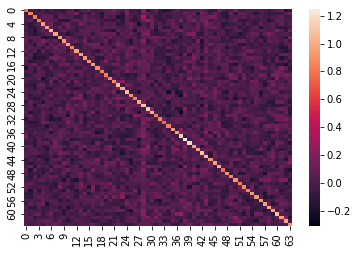

In [7]:
import seaborn as sns
sns.heatmap(adj)

In [8]:
from main import model_predict, print_classification_report

y_preds, y_test = model_predict(best_model, test_loader=dataloaders['test'])

cr, cm, auroc = print_classification_report(y_test, y_preds, PARAMS['N_CLASSES'])

In [9]:
print(cr)

{'0': {'precision': 0.6058091286307054, 'recall': 0.6431718061674009, 'f1-score': 0.6239316239316239, 'support': 227}, '1': {'precision': 0.5575221238938053, 'recall': 0.5806451612903226, 'f1-score': 0.5688487584650113, 'support': 217}, '2': {'precision': 0.45901639344262296, 'recall': 0.47257383966244726, 'f1-score': 0.46569646569646567, 'support': 237}, '3': {'precision': 0.5483870967741935, 'recall': 0.4817813765182186, 'f1-score': 0.5129310344827587, 'support': 247}, 'accuracy': 0.5420258620689655, 'macro avg': {'precision': 0.5426836856853318, 'recall': 0.5445430459095973, 'f1-score': 0.542851970643965, 'support': 928}, 'weighted avg': {'precision': 0.5417451198634196, 'recall': 0.5420258620689655, 'f1-score': 0.5410955680028985, 'support': 928}}


In [10]:
print(auroc)

0.6958838757340282


<AxesSubplot:>

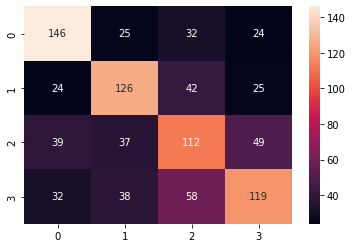

In [11]:
sns.heatmap(cm, annot=True, fmt='g')